# Wind Data Analysis - Multilinear Regression
 

This notebook develops a multilinear regression model trained on NAM forecast data to predict site-specific wind and temperature predictions. The model performance is also assessed.

## Load Data and Develop Dataframe for Regression

In [ ]:
# Dependencies and Setup
import pandas as pd
from datetime import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
## import scipy.stats as st # for linear regression model
## from scipy.stats import ttest_ind, ttest_rel
from sklearn.model_selection import train_test_split # for multilinear regression
from sklearn.linear_model import LinearRegression  # for multilinear regression
from sklearn.metrics import mean_squared_error  # for multilinear regression
from sklearn.preprocessing import StandardScaler   # for multilinear regression
## import statsmodels.api as sm # for multilinear regression

# Read in data
df_reg = pd.read_csv('data/df_3d_and_nam.csv', parse_dates=['date_3d', 'date_nam', 'time_utc', 'time_local','date_forecasted'])


In [ ]:
# Set which regression to do (set one to True, one to False)
run_temp = False
run_wind_speed = True
# Set whether or not to run wind direction regression (different from temp and wind speed regressions, so can be True or False)
run_wind_dir = True

if run_temp & run_wind_speed:
    print("Set only one of run_temp and run_wind_speed to true. By default, will run temp.")
    j = 0
elif run_temp:
    j = 0
elif run_wind_speed:
    j = 1
else:
    print("Either run_temp or run_wind_speed must be set to true. By default, will run temp.")
    j = 0

In [121]:
# Column names
print(df_reg.columns)

Index(['date_3d', 'hour_3d', 'minute_bin', 'wspd_mps_3d', 'wspd_mph_3d',
       'wdr_cos_3d', 'wdr_sin_3d', 'welv_3d', 'temp_C_3d', 'temp_F_3d',
       'wdr_3d', 'time_utc', 'forecast_period', 'wspd_mps_nam', 'wdr_nam',
       'welv_nam', 'temp_C_nam', 'kinetic_e', 'time_local', 'date_nam',
       'hour_nam', 'hour_forecasted', 'days_to_add', 'date_forecasted',
       'wdr_cos_nam', 'wdr_sin_nam', 'temp_F_nam', 'wspd_mph_nam', 'welv_diff',
       'wspd_mps_diff', 'wspd_mph_diff', 'wdr_diff', 'temp_C_diff',
       'temp_F_diff', 'wdr_nam_by10', 'wspd_mps_nam_by1', 'wspd_mph_nam_by1',
       'kinetic_e_by1', 'temp_F_nam_by1', 'wdr_3d_corr'],
      dtype='object')


In [122]:
# Drop some columns
df_reg.drop(columns=['date_3d', 'hour_3d', 'wspd_mps_3d', 'welv_3d', 'temp_C_3d', 
                     'time_utc','wspd_mps_nam','temp_C_nam',
                     'welv_diff', 'wspd_mps_diff', 'temp_C_diff', 
                     'wdr_nam_by10','wspd_mps_nam_by1','wspd_mph_nam_by1',
                     'kinetic_e_by1', 'temp_F_nam_by1', 'wdr_3d_corr','days_to_add'
                    ], inplace=True)

In [123]:
# Filter to usuable forecast periods
df_reg = df_reg[(df_reg['forecast_period']>=1) & (df_reg['forecast_period']<=12)]

In [124]:
# wind speeds greater than 1 m/s = 2.24 mph
df_reg = df_reg[ (df_reg['wspd_mph_nam']>=2.24) & (df_reg['wspd_mph_3d']>=2.24) ]

In [125]:
# Drop rows with null values
df_reg.dropna(inplace=True)

In [126]:
# Add day of year column
df_reg['day_of_year_forecasted'] = df_reg['date_forecasted'].dt.dayofyear
# Add cosine and sine of day_of_year_forecasted to account for cyclic nature of a year
df_reg['day_of_year_forecasted_cos'] = np.cos( df_reg['day_of_year_forecasted'] * 2 * math.pi/365 )
df_reg['day_of_year_forecasted_sin'] = np.sin( df_reg['day_of_year_forecasted'] * 2 * math.pi/365 )

In [127]:
# Add cosine and sine of hour_forecasted to account for cyclic nature of a day
df_reg['hour_forecasted_cos'] = np.cos( df_reg['hour_forecasted'] * math.pi/12 )
df_reg['hour_forecasted_sin'] = np.sin( df_reg['hour_forecasted'] * math.pi/12 )

In [128]:
# Make sure it is sorted by forecast time
df_reg.sort_values(by=['date_forecasted','hour_forecasted','minute_bin'],
                          ascending=[True, True, True],
                          inplace=True)

In [129]:
# Show info about the dataset
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, 101 to 4594
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   minute_bin                  1912 non-null   object        
 1   wspd_mph_3d                 1912 non-null   float64       
 2   wdr_cos_3d                  1912 non-null   float64       
 3   wdr_sin_3d                  1912 non-null   float64       
 4   temp_F_3d                   1912 non-null   float64       
 5   wdr_3d                      1912 non-null   float64       
 6   forecast_period             1912 non-null   float64       
 7   wdr_nam                     1912 non-null   float64       
 8   welv_nam                    1912 non-null   float64       
 9   kinetic_e                   1912 non-null   float64       
 10  time_local                  1912 non-null   datetime64[ns]
 11  date_nam                    1912 non-null   datetime64[ns]


In [130]:
print(f"NUmber data points: {len(df_reg)}")
print(f"Test size: {int(len(df_reg) * 0.2)}")
print(f"Train size: {len(df_reg)-int(len(df_reg) * 0.2)}")

NUmber data points: 1912
Test size: 382
Train size: 1530


## Multilinear Regression for Wind Speed and Temperature

### Form inputs

In [131]:
# Generate lag features 
# To account for the sequential nature of time series, you can create lagged features. For example, you might want to use values from previous time steps as additional features.
# Creating lagged features (lags of 1, 2, 3 periods)
df_reg['temp_F_nam_lag_b1'] = df_reg['temp_F_nam'].shift(-1)
df_reg['temp_F_nam_lag_b2'] = df_reg['temp_F_nam'].shift(-2)
df_reg['temp_F_nam_lag_f1'] = df_reg['temp_F_nam'].shift(1)
df_reg['temp_F_nam_lag_f2'] = df_reg['temp_F_nam'].shift(2)
df_reg['wdr_cos_nam_lag_b1'] = df_reg['wdr_cos_nam'].shift(-1)
df_reg['wdr_cos_nam_lag_b2'] = df_reg['wdr_cos_nam'].shift(-2)
df_reg['wdr_cos_nam_lag_f1'] = df_reg['wdr_cos_nam'].shift(1)
df_reg['wdr_cos_nam_lag_f2'] = df_reg['wdr_cos_nam'].shift(2)
df_reg['wdr_sin_nam_lag_b1'] = df_reg['wdr_sin_nam'].shift(-1)
df_reg['wdr_sin_nam_lag_b2'] = df_reg['wdr_sin_nam'].shift(-2)
df_reg['wdr_sin_nam_lag_f1'] = df_reg['wdr_sin_nam'].shift(1)
df_reg['wdr_sin_nam_lag_f2'] = df_reg['wdr_sin_nam'].shift(2)
df_reg['wspd_mph_nam_lag_b1'] = df_reg['wspd_mph_nam'].shift(-1)
df_reg['wspd_mph_nam_lag_b2'] = df_reg['wspd_mph_nam'].shift(-2)
df_reg['wspd_mph_nam_lag_f1'] = df_reg['wspd_mph_nam'].shift(1)
df_reg['wspd_mph_nam_lag_f2'] = df_reg['wspd_mph_nam'].shift(2)
df_reg['kinetic_e_lag_b1'] = df_reg['kinetic_e'].shift(-1)
df_reg['kinetic_e_lag_b2'] = df_reg['kinetic_e'].shift(-2)
df_reg['kinetic_e_lag_f1'] = df_reg['kinetic_e'].shift(1)
df_reg['kinetic_e_lag_f2'] = df_reg['kinetic_e'].shift(2)
df_reg.dropna(inplace=True)  # Remove rows with NaN values due to lagging

In [ ]:
# Independent variables
X = df_reg[['temp_F_nam', 
            'wdr_cos_nam', 
            'wdr_sin_nam', 
            'wspd_mph_nam',
            'forecast_period',
            'welv_nam',
            'kinetic_e',
            'hour_forecasted_cos',
            'hour_forecasted_sin',
            #'hour_forecasted',
           # 'day_of_year_forecasted_cos',
           # 'day_of_year_forecasted_sin',
            'day_of_year_forecasted',
            'temp_F_nam_lag_b1',
            'temp_F_nam_lag_b2',
            'temp_F_nam_lag_f1',
            'temp_F_nam_lag_f2',
            'wdr_cos_nam_lag_b1',
            'wdr_cos_nam_lag_b2',
            'wdr_cos_nam_lag_f1',
            'wdr_cos_nam_lag_f2',
            'wdr_sin_nam_lag_b1',
            'wdr_sin_nam_lag_b2',
            'wdr_sin_nam_lag_f1',
            'wdr_sin_nam_lag_f2',
            'wspd_mph_nam_lag_b1',
            'wspd_mph_nam_lag_b2',
            'wspd_mph_nam_lag_f1',
            'wspd_mph_nam_lag_f2',
            'kinetic_e_lag_b1',
            'kinetic_e_lag_b2',
            'kinetic_e_lag_f1',
            'kinetic_e_lag_f2',
            ]]

# Dependent variable (3 different models)
ys = [df_reg['temp_F_3d'], 
      df_reg['wspd_mph_3d'],
      ] 

# NAM forecast for comparison with prediction
nams = [df_reg['temp_F_nam'],
        df_reg['wspd_mph_nam'],
        ]

# Labels for graph
labels = ['Temperature, F',
          'Wind speed, mph']

# Set which regression to do (j=0,1,2)
y = ys[j]
nam = nams[j]
label = labels[j]

In [ ]:
# Look at X
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1908 entries, 139 to 4592
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   temp_F_nam              1908 non-null   float64
 1   wdr_cos_nam             1908 non-null   float64
 2   wdr_sin_nam             1908 non-null   float64
 3   wspd_mph_nam            1908 non-null   float64
 4   forecast_period         1908 non-null   float64
 5   welv_nam                1908 non-null   float64
 6   kinetic_e               1908 non-null   float64
 7   hour_forecasted_cos     1908 non-null   float64
 8   hour_forecasted_sin     1908 non-null   float64
 9   day_of_year_forecasted  1908 non-null   int32  
 10  temp_F_nam_lag_b1       1908 non-null   float64
 11  temp_F_nam_lag_b2       1908 non-null   float64
 12  temp_F_nam_lag_f1       1908 non-null   float64
 13  temp_F_nam_lag_f2       1908 non-null   float64
 14  wdr_cos_nam_lag_b1      1908 non-null   flo

In [ ]:
# Split the data into training and testing sets
# 80% train, 20% test split
# Must be done in blocks due to timeseries nature

# training set is first 80% of data, testing set last 20%
#train_size = int(len(df_reg) * 0.8)
#X_train, X_test = X[:train_size], X[train_size:]
#y_train, y_test = y[:train_size], y[train_size:]
#nam_train, nam_test = nam[:train_size], nam[train_size:]

# training set is last 80% of data, testing set first 20%
test_size = int(len(df_reg) * 0.2)
X_test, X_train = X[:test_size], X[test_size:]
y_test, y_train = y[:test_size], y[test_size:]
nam_test, nam_train = nam[:test_size], nam[test_size:]

In [135]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Transform the X data using the scaler
X_scaled = X_scaler.transform(X)

### Create model

In [136]:
# Train the multilinear regression model
model = LinearRegression(fit_intercept=True)
model.fit(X_train_scaled, y_train)

LinearRegression()

### Make predictions

In [137]:
# Make prediction
y_pred = model.predict(X_test_scaled)

df_reg["pred"] = model.predict(X_scaled)
df_reg["diff"] = df_reg["pred"] - y

### Histograms of differences between model and actual

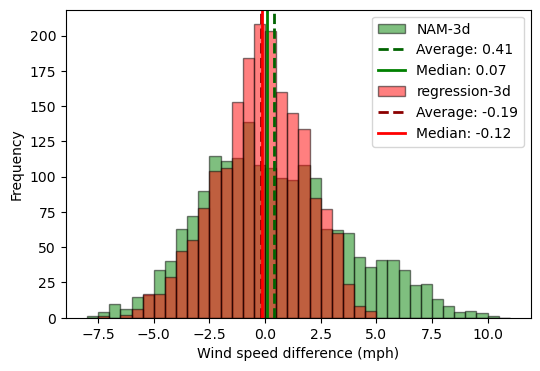

In [ ]:
# Histogram of differences

fig, ax = plt.subplots(1,1, figsize=(6,4))
if j==0:
    data = df_reg['temp_F_diff']
    xlabel = 'Temperature difference (F)'
    bin_width = 1  # Set your desired bin width
elif j==1:
    data = df_reg['wspd_mph_diff']
    xlabel = 'Wind speed difference (mph)'
    bin_width = 0.5  # Set your desired bin width
else:
    print("yikes! j must be 0 or 1!")
bin_edges = np.arange(np.floor(min(data)), np.ceil(max(data)) + bin_width, bin_width)
# Calculate the average and median
average = np.mean(data)
median = np.median(data)
# Histogram
ax.hist(data, bins=bin_edges, edgecolor='black', color='green', alpha=0.5, label="NAM-3d")  # bins=30 creates 30 bins, adjust as needed
# Add vertical lines for the average and median
ax.axvline(average, color='darkgreen', linestyle='--', linewidth=2, label=f'Average: {average:.2f}')
ax.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
# Repeat
data = df_reg["diff"]
average = np.mean(data)
median = np.median(data)
ax.hist(data, bins=bin_edges, edgecolor='black', color='red', alpha=0.5, label="regression-3d")  # bins=30 creates 30 bins, adjust as needed
ax.axvline(average, color='darkred', linestyle='--', linewidth=2, label=f'Average: {average:.2f}')
ax.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
# Add title and labels
ax.set_xlabel(xlabel)
ax.set_ylabel('Frequency')
# Show legend
ax.legend()

if j==0:
    plt.savefig("output/histogram_temp_diff_reg_nam_3d.png", bbox_inches='tight')
else:
    plt.savefig("output/histogram_wspd_diff_reg_nam_3d.png", bbox_inches='tight')

plt.show()

### Evaluate model

In [ ]:
# Evaluate the model by finding MSE and R^2

mse_model = mean_squared_error(y_test, y_pred)
print(f"{labels[j]}: Mean Squared Error of model prediction: {mse_model}")
mse_nam = mean_squared_error(y_test, nam_test)
print(f"{labels[j]}: Mean Squared Error of NAM forecast: {mse_nam}")

r_value_model = np.corrcoef(y_test, y_pred)[0, 1]
r_squared_model = r_value_model*r_value_model
print(f"{labels[j]}: R-value of model prediction: {r_value_model}")
print(f"{labels[j]}: R-squared of model prediction: {r_squared_model}")

r_value_nam = np.corrcoef(y_test, nam_test)[0, 1]
r_squared_nam = r_value_nam*r_value_nam
print(f"{labels[j]}: R-value of NAM forecast: {r_value_nam}")
print(f"{labels[j]}: R-squared of NAM forecast: {r_squared_nam}")

Wind speed, mph: Mean Squared Error of model prediction: 5.233818489817955
Wind speed, mph: Mean Squared Error of NAM forecast: 9.290045444904687
Wind speed, mph: R-value of model prediction: 0.7852796604029635
Wind speed, mph: R-squared of model prediction: 0.6166641450425937
Wind speed, mph: R-value of NAM forecast: 0.4441639381232815
Wind speed, mph: R-squared of NAM forecast: 0.1972816039291822


### Visualize regression prediction in timeseries

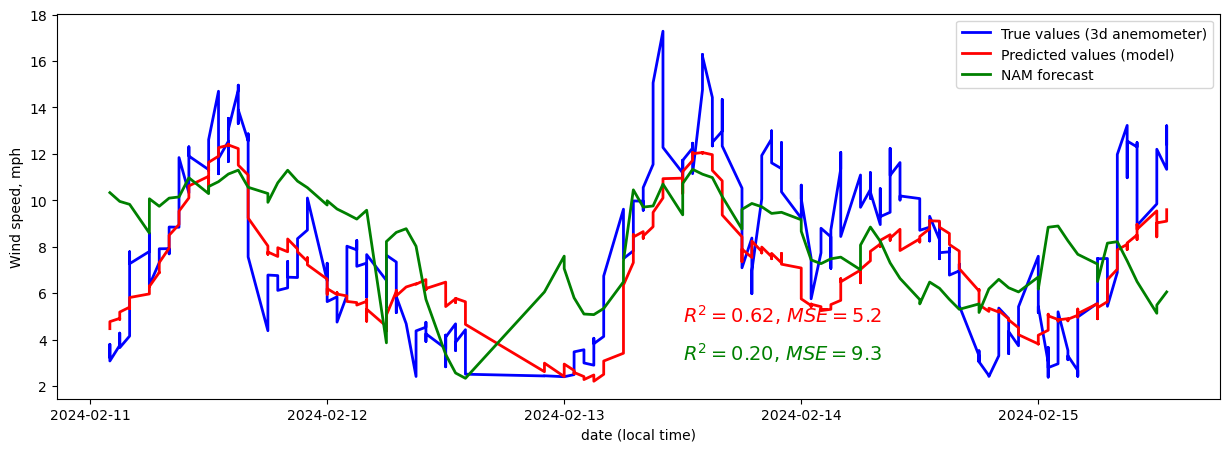

In [ ]:
# Visualize the regression predictions 

#x = pd.to_datetime(df_reg[train_size:]['date_forecasted']) + pd.to_timedelta(df_reg[train_size:]['hour_forecasted'], unit='h')
x = pd.to_datetime(df_reg[:test_size]['date_forecasted']) + pd.to_timedelta(df_reg[:test_size]['hour_forecasted'], unit='h')
xticks = list(df_reg[:test_size]['date_forecasted'].dt.date.unique())

plt.figure(figsize=(15, 5))
plt.plot(x, y_test, label='True values (3d anemometer)', color="blue", lw=2)
plt.plot(x, y_pred, label='Predicted values (model)', color="red", lw=2)
plt.plot(x, nam_test, label='NAM forecast',color="green", lw=2)
plt.xlabel('date (local time)')
plt.ylabel(label)
plt.xticks(xticks)
plt.legend()

# Get the current axis
ax = plt.gca()

# find position for text
y_max = ax.get_ylim()[1]
y_min = ax.get_ylim()[0]
height = y_max - y_min

# put R-squared values on plot
plt.text(datetime.strptime('2024-02-13 12', "%Y-%m-%d %H"), y_min + 0.2 * height,'$R^2 = %0.2f$'% r_squared_model + ', $MSE = %0.1f$'% mse_model, fontsize = 14, color='red')
plt.text(datetime.strptime('2024-02-13 12', "%Y-%m-%d %H"), y_min + 0.1 * height,'$R^2 = %0.2f$'% r_squared_nam + ', $MSE = %0.1f$'% mse_nam, fontsize = 14, color='green')

if j==0:
    plt.savefig("output/multilinear_temp.png", bbox_inches='tight')
else:
    plt.savefig("output/multilinear_wspd.png", bbox_inches='tight')

plt.show()

### Model coefficients

In [ ]:
# Find model coefficeints
# Positive coefficient: This means the variable has a positive influence on the target (increases as the variable increases).
# Negative coefficient: This means the variable has a negative influence on the target (decreases as the variable increases).
# However, coefficients alone can sometimes be hard to interpret, especially if the variables are measured in different units (e.g., one variable might be in dollars and another in kilograms).

print(f'Model coefficients {labels[j]}')

# Get the standardized coefficients and store them in a dataframe
standardized_coefficients = model.coef_
variables = []
coefficients = []
for feature, coef in zip(X.columns, standardized_coefficients):
    variables.append(feature)
    coefficients.append(coef)
df_to_export = pd.DataFrame({
    'Variables': variables,
    'Coefficients': coefficients
})

if j==0:
    df_to_export.to_csv('output/model_coefficients_temp.csv', index=False)  
else:
    df_to_export.to_csv('output/model_coefficients_wspd.csv', index=False)  

df_to_export

Model coefficients Wind speed, mph


,Variables,Coefficients
0,temp_F_nam,0.193738
1,wdr_cos_nam,-0.055581
2,wdr_sin_nam,-0.168020
3,wspd_mph_nam,0.312194
4,forecast_period,-0.060952
5,welv_nam,0.035435
6,kinetic_e,0.356500
7,hour_forecasted_cos,-0.872716
8,hour_forecasted_sin,-0.481483
9,day_of_year_forecasted,0.074061


## Multilinear Regression for Wind Direction (Seprate model due to circular nature of wind direction)

Wind direction cosine: Mean Squared Error of model prediction: 0.0480151176533347
Wind direction cosine: Mean Squared Error of NAM forecast: 0.05761638458625425
Wind direction sine: Mean Squared Error of model prediction: 0.03631909929553661
Wind direction sine: Mean Squared Error of NAM forecast: 0.027384449387456395
Wind direction cosine: R-value of model prediction: 0.8476677980051586
Wind direction cosine:  R-squared of model prediction: 0.7185406957749143
Wind direction cosine: R-value of NAM forecast: 0.8574060626978565
Wind direction cosine: R-squared of NAM forecast: 0.7351451563510406
Wind direction sine: R-value of model prediction: 0.8125967241303453
Wind direction sine:  R-squared of model prediction: 0.6603134360673686
Wind direction sine: R-value of NAM forecast: 0.8288284477808792
Wind direction sine: R-squared of NAM forecast: 0.7106425360637796
-----------------------------
Model coefficients wind direction cosine
                 Variables  Coefficients
0             

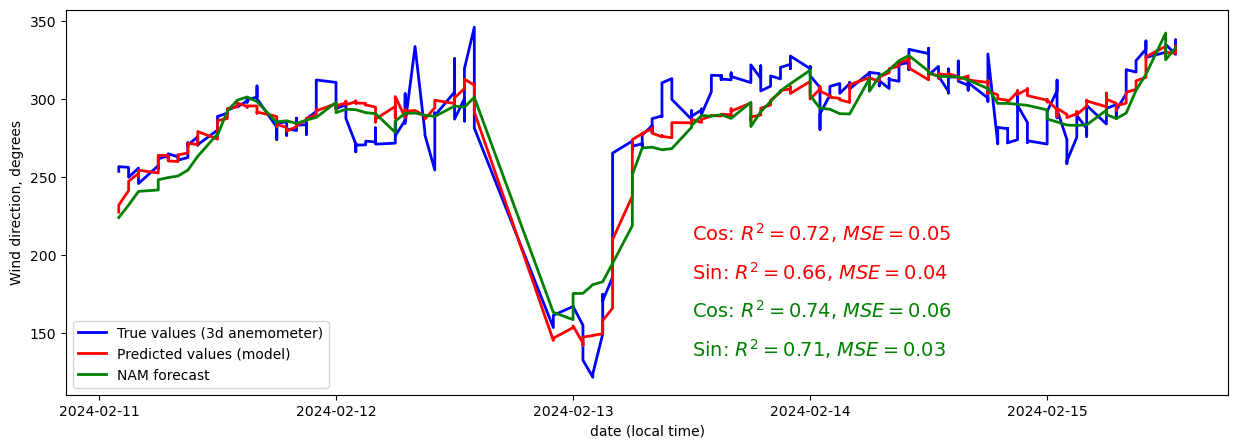

In [142]:
if run_wind_dir: # run regression if run_wind_dir=True

    y_cos = df_reg['wdr_cos_3d']
    y_sin = df_reg['wdr_sin_3d']
    y = df_reg['wdr_3d']
    nam_cos = df_reg['wdr_cos_nam']
    nam_sin = df_reg['wdr_sin_nam']
    nam = df_reg['wdr_nam']
    label = 'Wind direction, degrees'
    output_filepath = 'output/multilinear_wdr.png'

    y_cos_test, y_cos_train = y_cos[:test_size], y_cos[test_size:]
    y_sin_test, y_sin_train = y_sin[:test_size], y_sin[test_size:]
    y_test, y_train = y[:test_size], y[test_size:]
    nam_cos_test, nam_cos_train = nam_cos[:test_size], nam_cos[test_size:]
    nam_sin_test, nam_sin_train = nam_sin[:test_size], nam_sin[test_size:]
    nam_test, nam_train = nam[:test_size], nam[test_size:]

    # Train the multilinear regression model
    model_cos = LinearRegression(fit_intercept=True)
    model_cos.fit(X_train_scaled, y_cos_train)
    model_sin = LinearRegression(fit_intercept=True)
    model_sin.fit(X_train_scaled, y_sin_train)

    # Make prediction
    y_cos_pred = model_cos.predict(X_test_scaled)
    y_sin_pred = model_sin.predict(X_test_scaled)
    y_pred = (np.arctan2(y_sin_pred,y_cos_pred)* 180 / np.pi) % 360
    df_reg["pred"] =  (np.arctan2(model_sin.predict(X_scaled),model_cos.predict(X_scaled))* 180 / np.pi) % 360
    df_reg['diff'] = df_reg['pred'] - y + (df_reg['pred'] - y<-180)*360 -  (df_reg['pred'] - y>180)*360


    # Evaluate the model
    mse_model_cos = mean_squared_error(y_cos_test, y_cos_pred)
    print(f"Wind direction cosine: Mean Squared Error of model prediction: {mse_model_cos}")
    mse_nam_cos = mean_squared_error(y_cos_test, nam_cos_test)
    print(f"Wind direction cosine: Mean Squared Error of NAM forecast: {mse_nam_cos}")
    mse_model_sin = mean_squared_error(y_sin_test, y_sin_pred)
    print(f"Wind direction sine: Mean Squared Error of model prediction: {mse_model_sin}")
    mse_nam_sin = mean_squared_error(y_sin_test, nam_sin_test)
    print(f"Wind direction sine: Mean Squared Error of NAM forecast: {mse_nam_sin}")

    r_value_model_cos = np.corrcoef(y_cos_test, y_cos_pred)[0, 1]
    r_squared_model_cos = r_value_model_cos*r_value_model_cos
    print(f"Wind direction cosine: R-value of model prediction: {r_value_model_cos}")
    print(f"Wind direction cosine:  R-squared of model prediction: {r_squared_model_cos}")
    r_value_nam_cos = np.corrcoef(y_cos_test, nam_cos_test)[0, 1]
    r_squared_nam_cos = r_value_nam_cos*r_value_nam_cos
    print(f"Wind direction cosine: R-value of NAM forecast: {r_value_nam_cos}")
    print(f"Wind direction cosine: R-squared of NAM forecast: {r_squared_nam_cos}")

    r_value_model_sin = np.corrcoef(y_sin_test, y_sin_pred)[0, 1]
    r_squared_model_sin = r_value_model_sin*r_value_model_sin
    print(f"Wind direction sine: R-value of model prediction: {r_value_model_sin}")
    print(f"Wind direction sine:  R-squared of model prediction: {r_squared_model_sin}")
    r_value_nam_sin = np.corrcoef(y_sin_test, nam_sin_test)[0, 1]
    r_squared_nam_sin = r_value_nam_cos*r_value_nam_sin
    print(f"Wind direction sine: R-value of NAM forecast: {r_value_nam_sin}")
    print(f"Wind direction sine: R-squared of NAM forecast: {r_squared_nam_sin}")

    x = pd.to_datetime(df_reg[:test_size]['date_forecasted']) + pd.to_timedelta(df_reg[:test_size]['hour_forecasted'], unit='h')

    print('-----------------------------')

    # Model coefficients

    print('Model coefficients wind direction cosine')

    # Get the standardized coefficients and store them in a dataframe
    standardized_coefficients_cos = model_cos.coef_
    variables = []
    coefficients = []
    for feature, coef in zip(X.columns, standardized_coefficients_cos):
        variables.append(feature)
        coefficients.append(coef)
    df_to_export = pd.DataFrame({
        'Variables': variables,
        'Coefficients': coefficients
    })
    df_to_export.to_csv(f'output/model_coefficients_cos.csv', index=False)  
    print(df_to_export)

    print('-----------------------------')

    print('Model coefficients wind direction sine')

    # Get the standardized coefficients and store them in a dataframe
    standardized_coefficients_sin = model_sin.coef_
    variables = []
    coefficients = []
    for feature, coef in zip(X.columns, standardized_coefficients_sin):
        variables.append(feature)
        coefficients.append(coef)
    df_to_export = pd.DataFrame({
        'Variables': variables,
        'Coefficients': coefficients
    })
    df_to_export.to_csv(f'output/model_coefficients_sin.csv', index=False)  
    print(df_to_export)


    # Visualize the results 

    xticks = list(df_reg[:test_size]['date_forecasted'].dt.date.unique())

    plt.figure(figsize=(15, 5))
    plt.plot(x, y_test, label='True values (3d anemometer)', color="blue", lw=2)
    plt.plot(x, y_pred, label='Predicted values (model)', color="red", lw=2)
    plt.plot(x, nam_test, label='NAM forecast',color="green", lw=2)
    plt.xlabel('date (local time)')
    plt.xticks(xticks)
    plt.ylabel(label)
    plt.legend()

    # Get the current axis
    ax = plt.gca()

    # find position for text
    y_max = ax.get_ylim()[1]
    y_min = ax.get_ylim()[0]
    height = y_max - y_min

    # put R-squared values on plot
    plt.text(datetime.strptime('2024-02-13 12', "%Y-%m-%d %H"), y_min + 0.4 * height,'Cos: $R^2 = %0.2f$'% r_squared_model_cos + ', $MSE = %0.2f$'% mse_model_cos, fontsize = 14, color='red')
    plt.text(datetime.strptime('2024-02-13 12', "%Y-%m-%d %H"), y_min + 0.3 * height,'Sin: $R^2 = %0.2f$'% r_squared_model_sin + ', $MSE = %0.2f$'% mse_model_sin, fontsize = 14, color='red')
    plt.text(datetime.strptime('2024-02-13 12', "%Y-%m-%d %H"), y_min + 0.2 * height,'Cos: $R^2 = %0.2f$'% r_squared_nam_cos + ', $MSE = %0.2f$'% mse_nam_cos, fontsize = 14, color='green')
    plt.text(datetime.strptime('2024-02-13 12', "%Y-%m-%d %H"), y_min + 0.1 * height,'Sin: $R^2 = %0.2f$'% r_squared_nam_sin + ', $MSE = %0.2f$'% mse_nam_sin, fontsize = 14, color='green')

    plt.savefig(output_filepath, bbox_inches='tight')
    plt.show()

else:
    pass  # Do nothing

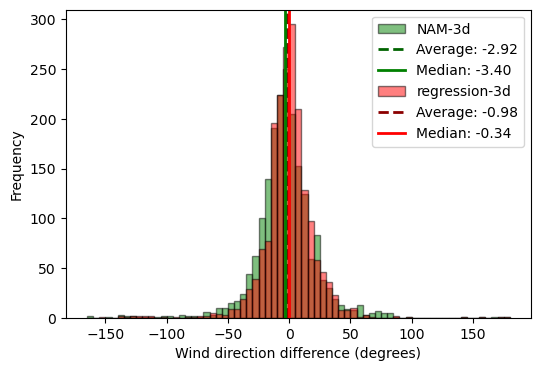

In [ ]:
if run_wind_dir: # run if run_wind_dir=True

    # Histogram of differences
    
    fig, ax = plt.subplots(1,1, figsize=(6,4))

    data = df_reg['wdr_diff']

    # Set desired bin width
    bin_width = 5
    bin_edges = np.arange(np.floor(min(data)), np.ceil(max(data)) + bin_width, bin_width)

    xlabel = "Wind direction difference (degrees)"
    # Calculate the average and median
    average = np.mean(data)
    median = np.median(data)
    # Histogram
    ax.hist(data, bins=bin_edges, edgecolor='black', color='green', alpha=0.5, label="NAM-3d")  # bins=30 creates 30 bins, adjust as needed
    # Add vertical lines for the average and median
    ax.axvline(average, color='darkgreen', linestyle='--', linewidth=2, label=f'Average: {average:.2f}')
    ax.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
    # Repeat
    data = df_reg["diff"]
    average = np.mean(data)
    median = np.median(data)
    ax.hist(data, bins=bin_edges, edgecolor='black', color='red', alpha=0.5, label="regression-3d")  # bins=30 creates 30 bins, adjust as needed
    ax.axvline(average, color='darkred', linestyle='--', linewidth=2, label=f'Average: {average:.2f}')
    ax.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
    # Add title and labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    # Show legend
    ax.legend()

    plt.savefig("output/histogram_wdr_diff_reg_nam_3d.png", bbox_inches='tight')

    plt.show()

else:
    pass  # Do nothing

In [144]:
# Clears all variables and the entire namespace
%reset -f